# Trip and Census Matched Data
This analysis uses less precise estimates, inferring individual characteristics from census level data and without any ecological regression.

In [1]:
suppressMessages(library(tidyverse))
library(RSQLCipher)
suppressMessages(library(lubridate))
suppressMessages(library(plm))

In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
db_path = "../../../db/hot-v3.db"

In [3]:
trips_2pct <- load_table(db_path, "trips_2pct")
acs_est <- read.csv("../../../data/block_group_census_estimates_wide_pc_income.csv")

In [4]:
trip <- trips_2pct %>%
    select(toll, 
           med_inc, 
           entry_time, 
          entry_plaza,
          id,
          tag_id,
          population,
          fips,
          is_hov,
          freq,
          commercial,
          total_trips,
          trip_id) %>%
    execute

In [5]:
acs_est <- acs_est %>%
    rename(fips = fips_code)

trip <- merge(trip, acs_est, by = "fips") %>%
    rename(med_inc = med_inc.y) %>%
    select(-med_inc.x, -pc_income)

## Analysis of Fare and Trip Demographics

In [6]:
fare_rounded <- trip
fare_rounded <- na.omit(fare_rounded)
fare_rounded$toll <- round(fare_rounded$toll / .25) * .25
head(fare_rounded)

,fips,toll,entry_time,entry_plaza,id,tag_id,population.x,is_hov,freq,commercial,⋯,inc_150_200k,inc_200_infk,med_age,med_inc,population.y,race_nonhisp_asian,race_nonhisp_white,trans_carpool,trans_drivealone,trans_transit
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,5.3033e+11,0.75,1529504361,13,-2.429657e+18,1.614027e+18,1265,0,2_monthly,0,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
3,5.3033e+11,0.00,1535462923,8,7.234689e+18,3.938452e+18,1265,1,3_weekly,0,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
5,5.3033e+11,0.00,1534339155,5,8.608467e+18,6.212821e+18,1265,1,2_monthly,0,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
6,5.3033e+11,0.75,1514909855,13,-4.816784e+18,7.830558e+18,1265,0,4_regular,0,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
8,5.3033e+11,5.25,1533294286,15,-8.557265e+18,-4.369736e+18,1265,0,2_monthly,0,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
9,5.3033e+11,0.75,1534866757,13,3.424591e+18,-6.291021e+18,1265,0,2_monthly,0,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586


### Fares by average median income

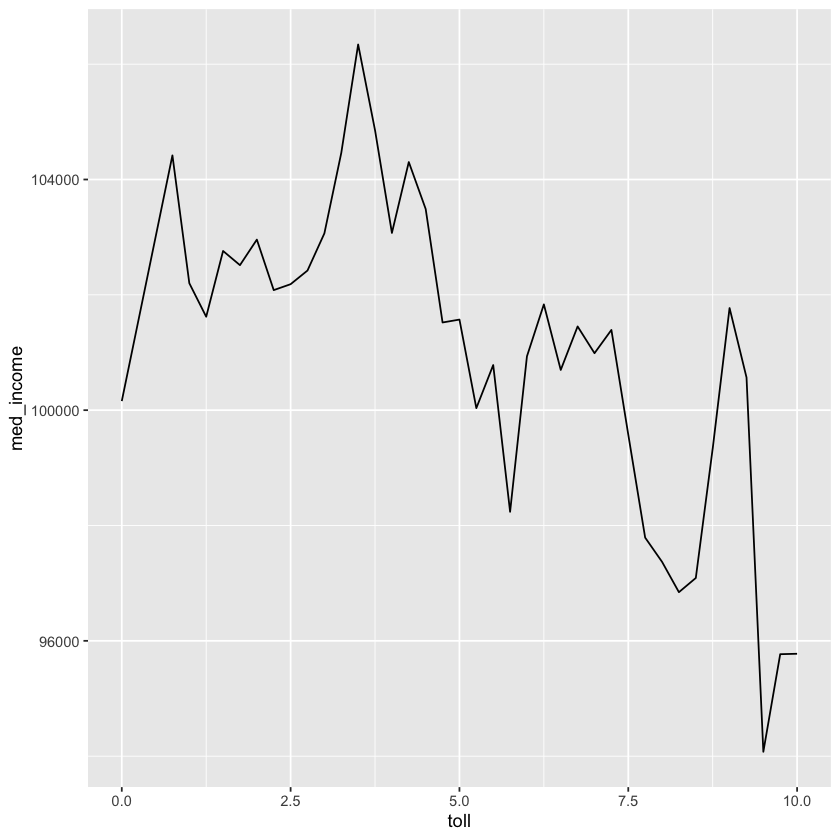

In [7]:
test <- fare_rounded %>%
    group_by(toll) %>%
    summarize(med_income = mean(med_inc)) 

ggplot(test) +
    geom_line(aes(x = toll, y = med_income))

### Fares by Race
This relationship makes sense due to the colinearlity between race and income blocks

toll,white
<dbl>,<dbl>
0.00,0.6747994
0.75,0.6829403
1.00,0.6988680
1.25,0.6952840
1.50,0.6974357
1.75,0.6958237


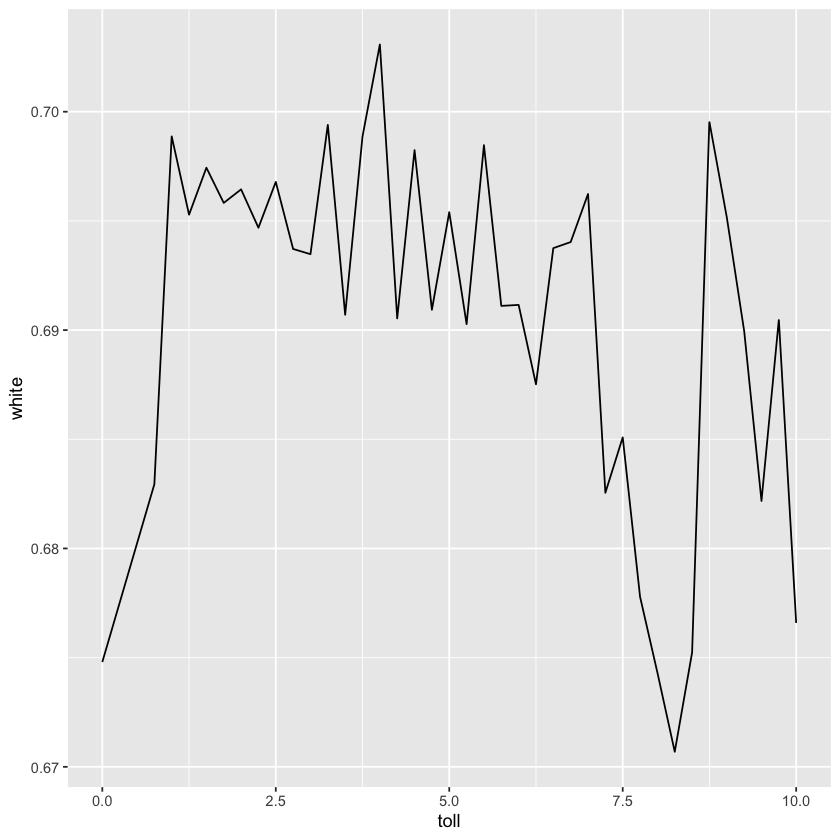

In [8]:
race <- fare_rounded %>%
    group_by(toll) %>%
    summarize(white = mean(race_nonhisp_white))

head(race)

ggplot(race, aes(x = toll, y = white)) +
    geom_line()

### "Weighted Income"
Kiana suggested using a weighted score by multplying the mean by the count of each fare type to normalize it, but creates a distribution very similar to the distribution of overall frequency of users for that fare amount.

In [9]:
income_count <- fare_rounded %>%
    select(toll, med_inc) %>%
    group_by(toll) %>%
    summarize(count = n(),
             mean = mean(med_inc),
             weighted = mean * count)

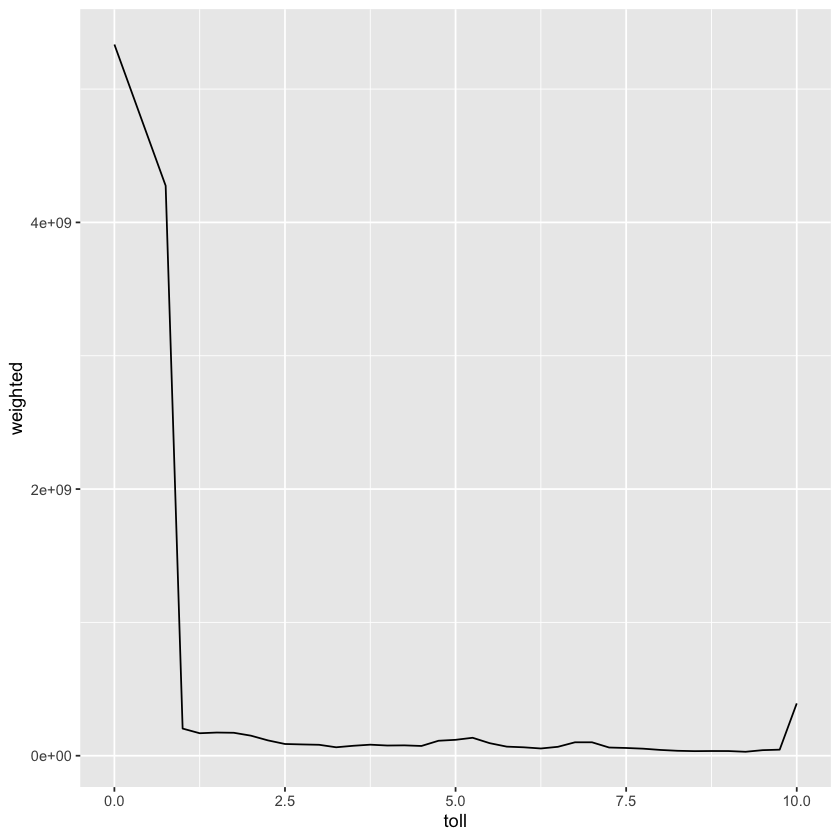

In [10]:
ggplot(income_count, aes(x = toll, y = weighted)) +
       geom_line()

## Analysis of Time and Income

In [11]:
time_space <- fare_rounded

In [12]:
time_space <- na.omit(time_space)
time_space$entry_time <- as_datetime(time_space$entry_time, tz = "UTC")
head(time_space)
time_space$entry_hour <- format(as.POSIXct(time_space$entry_time,format="%Y:%m:%d %H:%M:%S"),"%H" )

,fips,toll,entry_time,entry_plaza,id,tag_id,population.x,is_hov,freq,commercial,⋯,inc_150_200k,inc_200_infk,med_age,med_inc,population.y,race_nonhisp_asian,race_nonhisp_white,trans_carpool,trans_drivealone,trans_transit
,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,5.3033e+11,0.75,2018-06-20 14:19:21,13,-2.429657e+18,1.614027e+18,1265,0,2_monthly,0,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
3,5.3033e+11,0.00,2018-08-28 13:28:43,8,7.234689e+18,3.938452e+18,1265,1,3_weekly,0,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
5,5.3033e+11,0.00,2018-08-15 13:19:15,5,8.608467e+18,6.212821e+18,1265,1,2_monthly,0,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
6,5.3033e+11,0.75,2018-01-02 16:17:35,13,-4.816784e+18,7.830558e+18,1265,0,4_regular,0,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
8,5.3033e+11,5.25,2018-08-03 11:04:46,15,-8.557265e+18,-4.369736e+18,1265,0,2_monthly,0,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586
9,5.3033e+11,0.75,2018-08-21 15:52:37,13,3.424591e+18,-6.291021e+18,1265,0,2_monthly,0,⋯,0.1529605,0.3009868,54,118026,1265,0.07667984,0.8774704,0.1010249,0.6105417,0.1200586


### Median Income by Hour of Day
##### Ohhh boy
This analysis is suprising given the graphs above. The first graph using median income seems to demonstrate that **high-income people represent a higher proportion of users during peak times than low-income people** . As will later be discussed, this becomes more complicated. 

In [13]:
hours <- time_space %>%
    group_by(entry_hour) %>%
    summarize(med_inc = mean(med_inc),
            mean_fare = mean(toll))

head(hours)

entry_hour,med_inc,mean_fare
<chr>,<dbl>,<dbl>
05,92435.29,0.5656155
06,98155.08,1.7057550
07,101234.84,2.2988911
08,102311.76,2.6673417
09,102822.28,1.5910950
10,103367.41,0.6670433


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


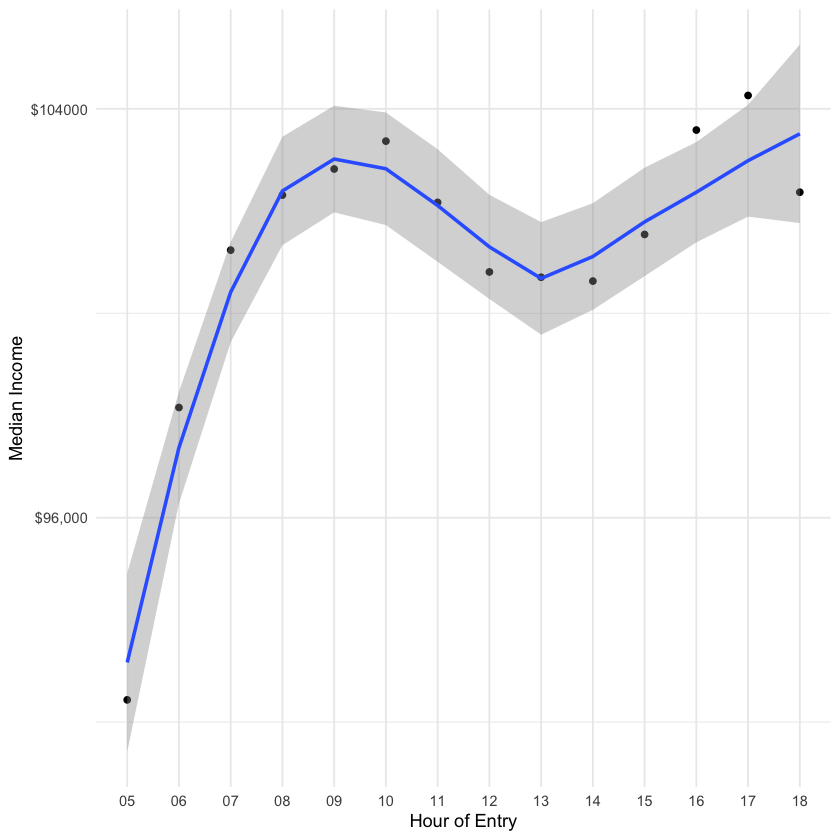

In [14]:
ggplot(hours, aes(x = entry_hour, group = 1)) +
    geom_point(aes(y = med_inc)) +
    geom_smooth(aes(y = med_inc)) + 
    labs(x = "Hour of Entry", y = "Median Income") +
    theme_minimal() +
    scale_y_continuous(breaks = c(96000, 10000, 104000), labels = c("$96,000", "$100,000", "$104000"))

#### Average Fares per Hour
The trend follows how the fare is tracked across times during the day.

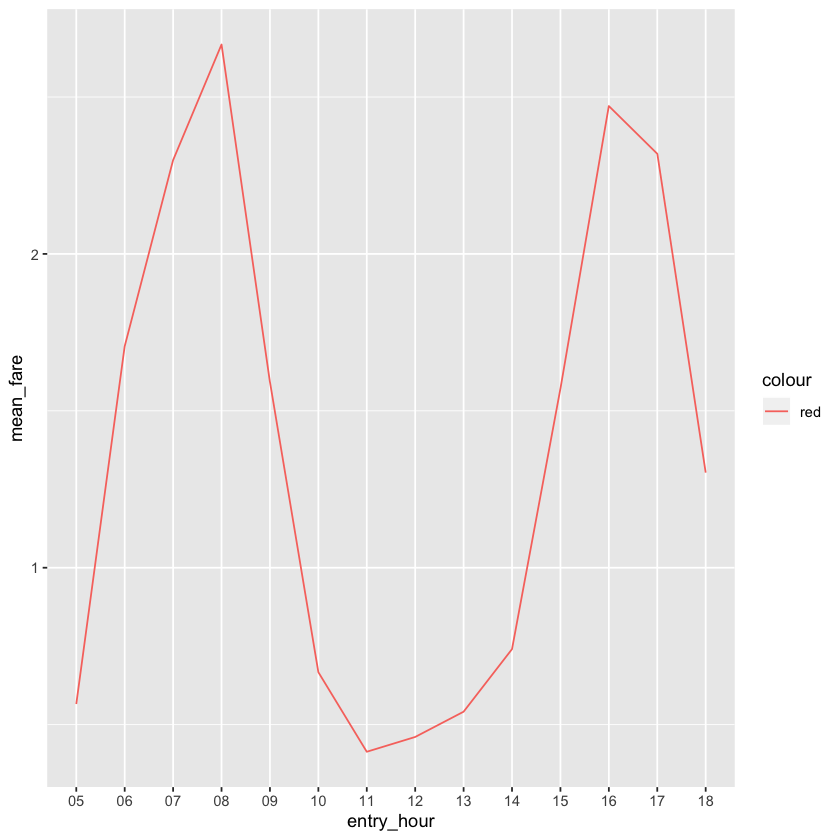

In [15]:
ggplot(hours, aes(x = entry_hour, group = 1)) +
    geom_line(aes(y = mean_fare, color = "red"))

### Income Groups by Hour of Day
In the same style as Cory, I looked at the average of the distributions of each income group over each day of the hour. This describes the trends of each income group by proportion they take up in the HOT lanes. The graphs show poorer income groups have a **reverse commuting style**, that is, they decrease use in peak times in contrast to high-income users. 

geom_smooth: na.rm = FALSE, se = TRUE
stat_smooth: na.rm = FALSE, se = TRUE, method = auto, formula = y ~ x
position_identity 

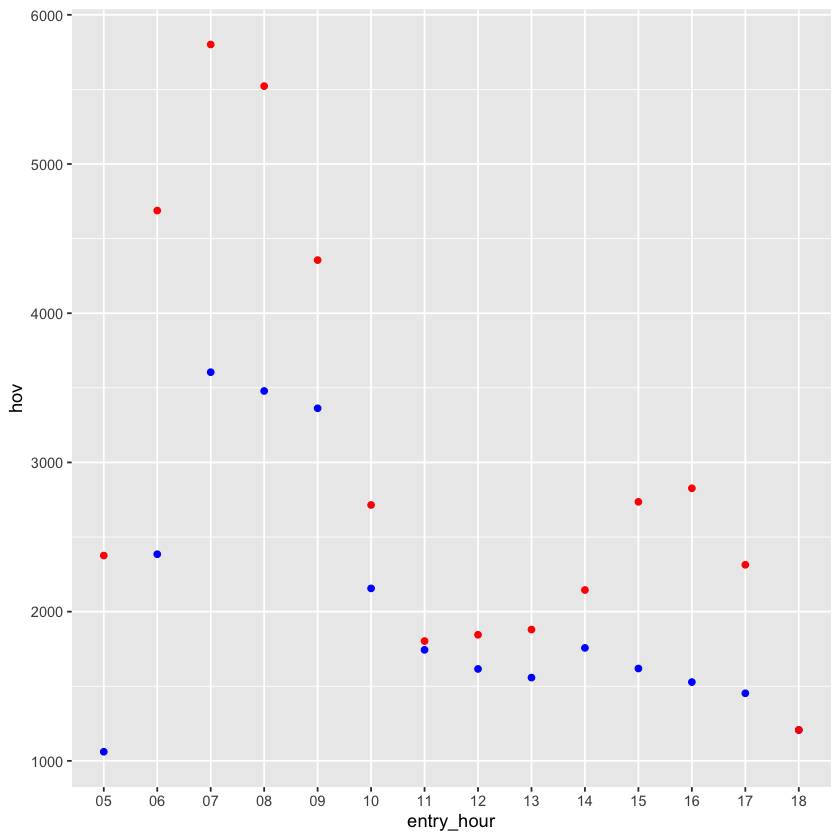

In [16]:
time_space %>%
    filter(entry_plaza > 12) %>%
    group_by(entry_hour) %>%
    summarize(hov = sum(is_hov),
             sov = n() - hov) %>%
ggplot(aes(entry_hour,  group = 1)) +
    geom_point(aes(y = hov), color = "blue") + 
    geom_point(aes(y = sov), color = "red")
    geom_smooth()

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


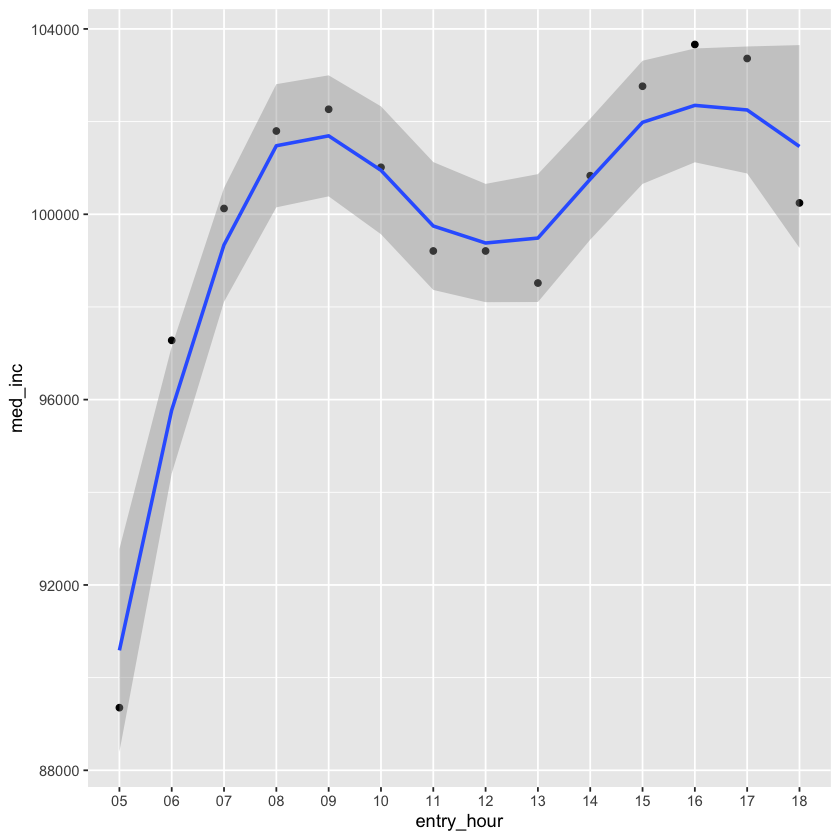

In [17]:
# Creates a random sample from the data
time_space %>%
    filter(entry_plaza > 12) %>%
    group_by(entry_hour) %>%
    summarize(med_inc = median(med_inc)) %>%
ggplot(aes(entry_hour, med_inc,  group = 1)) +
    geom_point() + 
    geom_smooth()

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


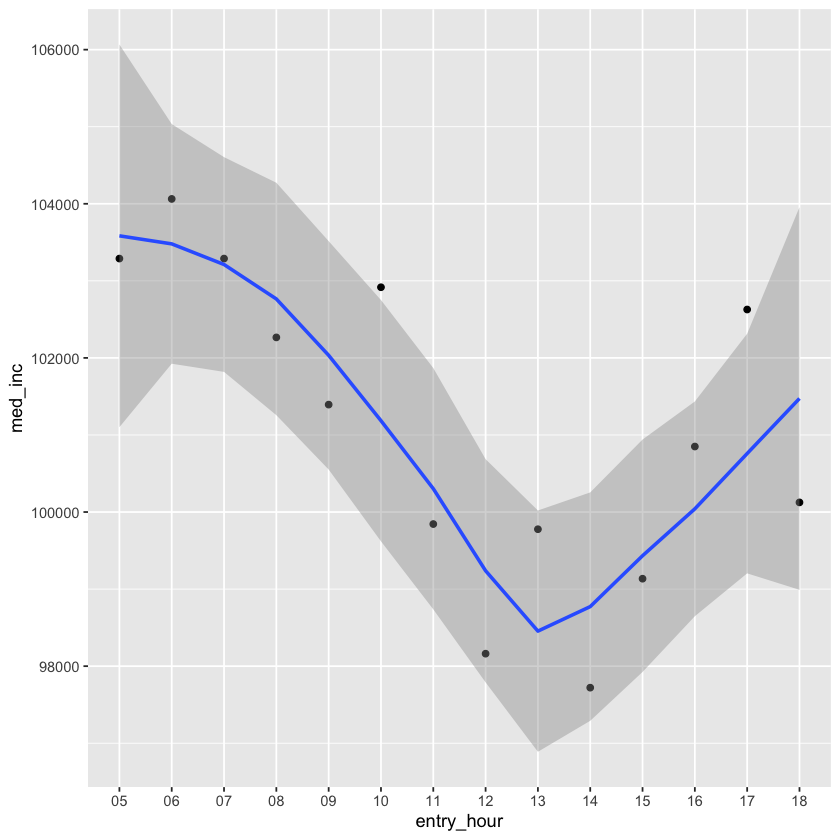

In [18]:
time_space %>%
    filter(entry_plaza <= 12) %>%
    group_by(entry_hour) %>%
    summarize(med_inc = median(med_inc)) %>%
ggplot(aes(entry_hour, med_inc,  group = 1)) +
    geom_point() +
    geom_smooth()

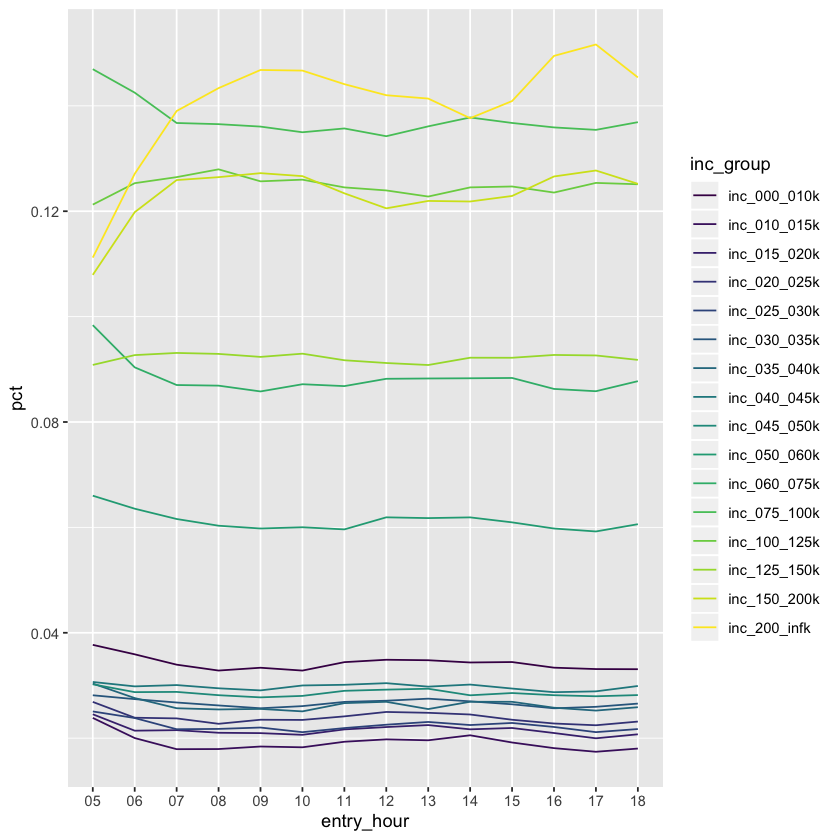

In [19]:
time_space %>%
    group_by(entry_hour) %>%
    select(-med_inc) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    gather(inc_group, pct, -entry_hour) %>%
ggplot(aes(entry_hour, pct, color = inc_group, group = inc_group)) +
    geom_line() +
    scale_color_viridis_d() 

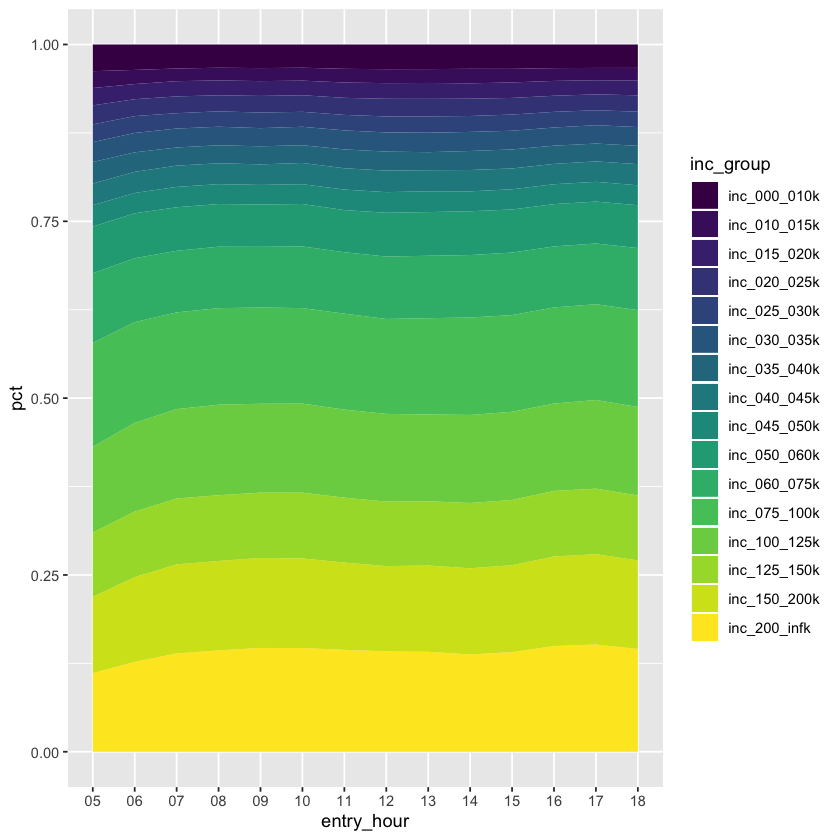

In [21]:
time_space %>%
    group_by(entry_hour) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    select(-med_inc) %>%
    gather(inc_group, pct, -entry_hour) %>%
ggplot(aes(entry_hour, pct, fill = inc_group, group = inc_group)) +
    geom_area() +
    scale_fill_viridis_d() 

### Proportions of Income Group Distributions
The proportions of the groups above seems odd, since the graph indicates the lowest and highest income groups represent the largest proportion of users during most of the day. There is still a lot of questions to be asked and answered here, but first we wanted to see how the income groups are actually distributed throughout this sample and in the general census data itself. 

##### Count of Census Blocks with Differing Proportions of Those in 75-100k Income Group

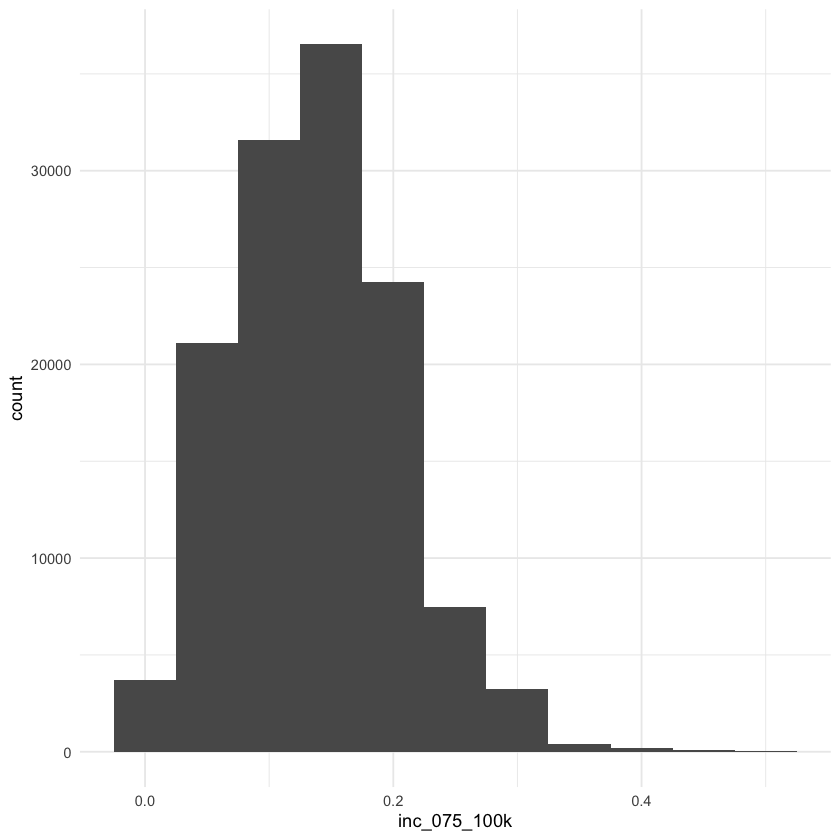

In [22]:
ggplot(time_space, aes(x = inc_075_100k)) +
    geom_histogram(binwidth = .05) +
    theme_minimal()

##### Aggregated Proportions for Each Census Block in the Sample

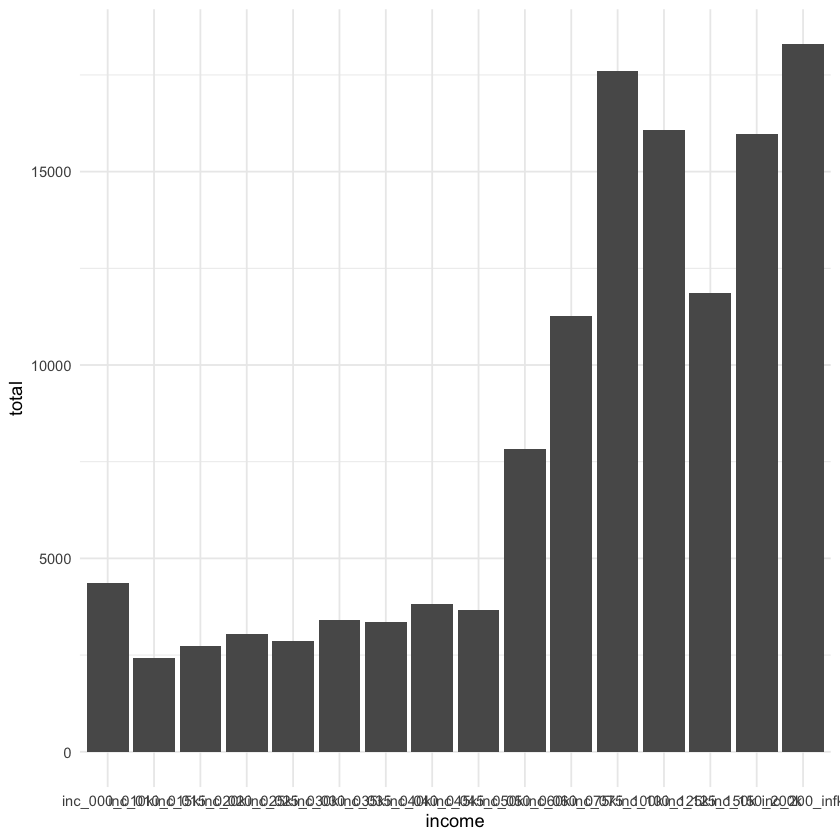

In [24]:
time_space %>%
    select(-med_inc) %>%
    summarize_at(vars(contains("inc")), sum, na.rm=T) %>%
    gather(income, total, inc_000_010k:inc_200_infk) %>%
ggplot(aes(x = income, y = total)) +
    geom_bar(stat = "identity") +
    theme_minimal()

### Seperating by NB and SB Commute

#### Southbound Income Group Graph Over Time

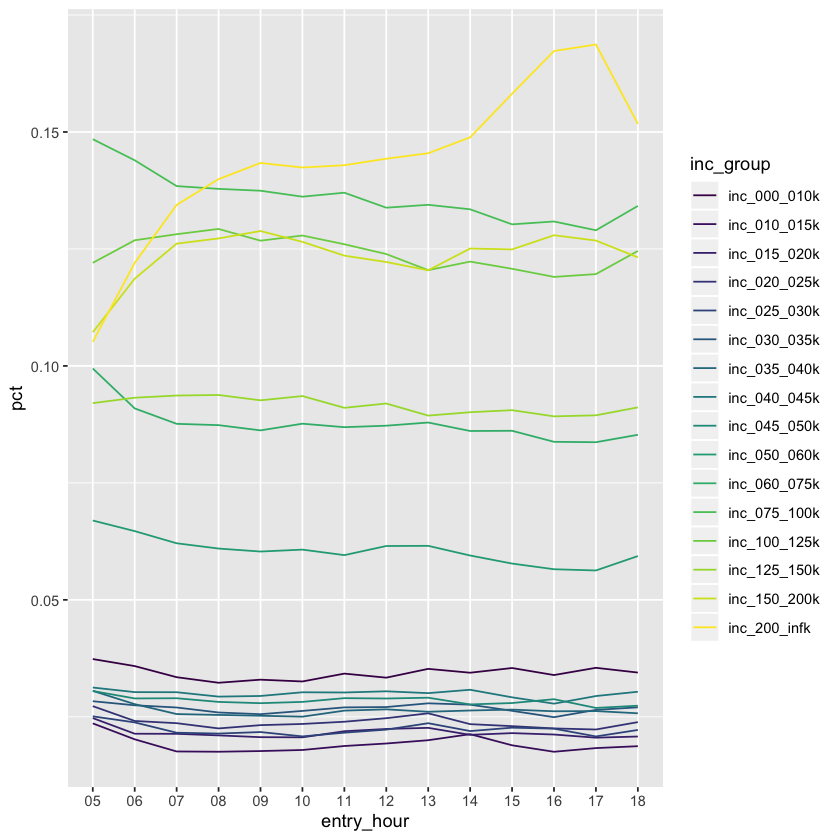

In [25]:
time_space %>%
    filter(entry_plaza > 12) %>%
    group_by(entry_hour) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    select(-med_inc) %>%
    gather(inc_group, pct, -entry_hour) %>%
ggplot(aes(entry_hour, pct, color = inc_group, group = inc_group)) +
    geom_line() +
    scale_color_viridis_d() 

#### Northbound Income Group Graph Over Time

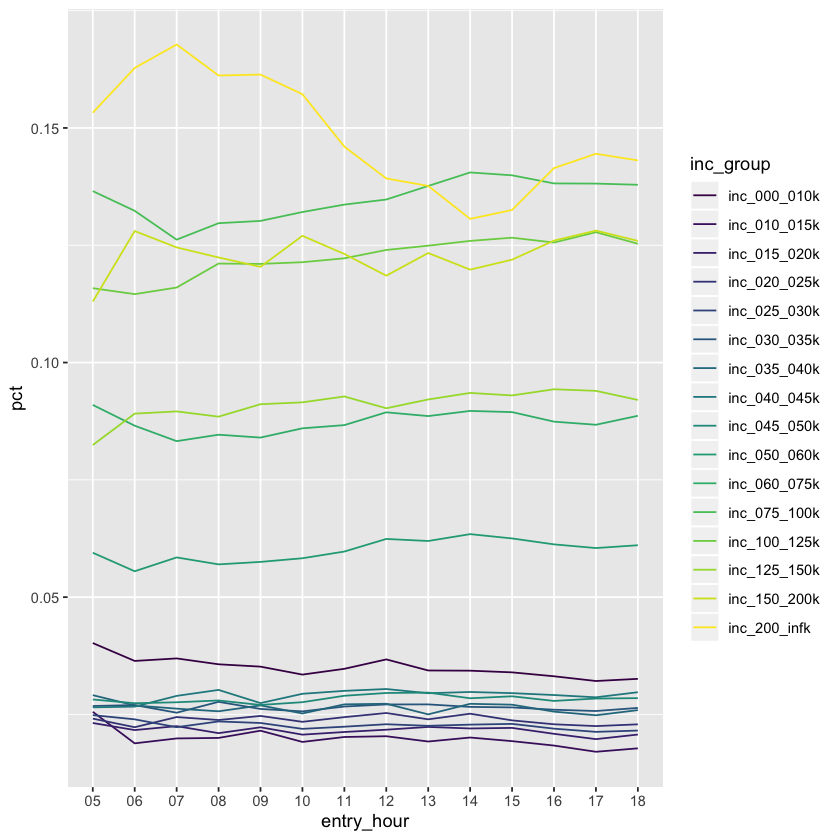

In [26]:
time_space %>%
    filter(entry_plaza <= 12) %>%
    group_by(entry_hour) %>%
    summarize_at(vars(contains("inc")), mean, na.rm=T) %>%
    select(-med_inc,) %>%
    gather(inc_group, pct, -entry_hour) %>%
ggplot(aes(entry_hour, pct, color = inc_group, group = inc_group)) +
    geom_line() +
    scale_color_viridis_d() 

## Income Totals

Percentage of Fare by Income Groups

Average Proportion of Low Income People by Fare Paid

In [28]:
income_share <- trip %>%
    select(id,
          toll,
          contains("inc")) %>% 
    group_by(id) %>%
    summarize(fare_sum = sum(toll),
            low_income = mean(inc_000_010k)) %>% # this should return total fare a user paid as well as their census info
    filter(fare_sum < 10000) %>% # there were several outliers that skewed the data very heavily
    na.omit()

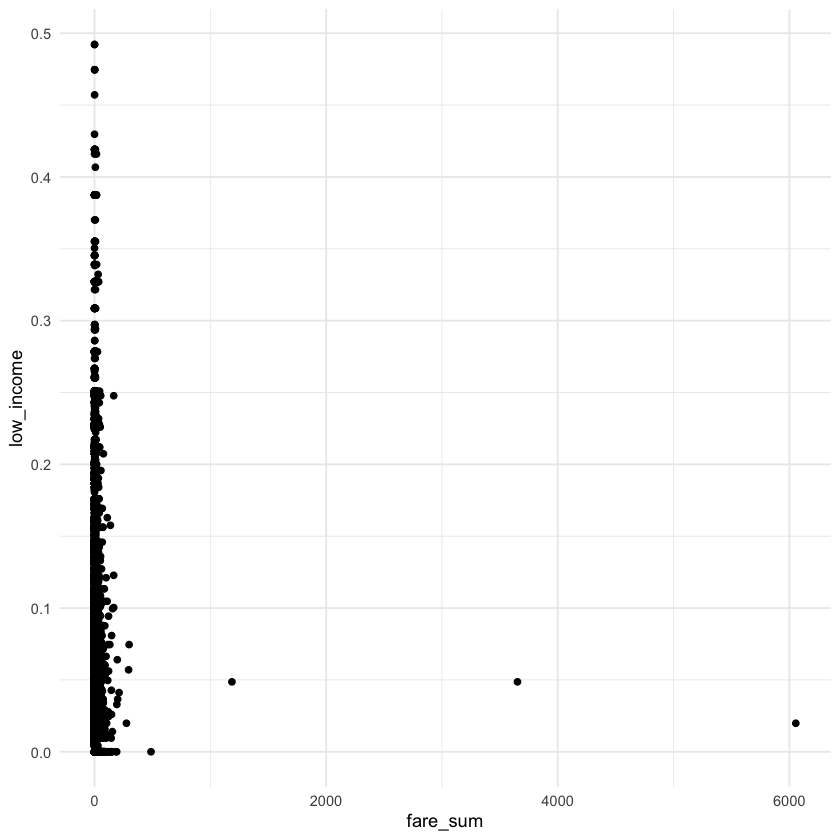

In [29]:
ggplot(income_share, aes(x = fare_sum, y = low_income)) +
    geom_point() +
    theme_minimal()

In [32]:
income_share_aggregate <- trip %>%
    select(id,
          toll,
          contains("inc")) %>% 
    group_by(id) %>%
    summarize(fare_sum = sum(toll),
            low_income = mean(inc_000_010k),
             ) %>% # this should return total fare a user paid as well as their census info
    na.omit() %>%
    filter(fare_sum < 10000) %>% # there were several outliers that skewed the data very heavily 
    group_by(fare_group = cut(fare_sum, breaks = seq(0, max(fare_sum), 500))) %>%
    summarize(mean_low_income = mean(low_income))

head(income_share_aggregate)

Warning message:
“Factor `fare_group` contains implicit NA, consider using `forcats::fct_explicit_na`”

fare_group,mean_low_income
<fct>,<dbl>
"(0,500]",0.03736203
"(1e+03,1.5e+03]",0.04865772
"(3.5e+03,4e+03]",0.04865772
NA,0.03476273


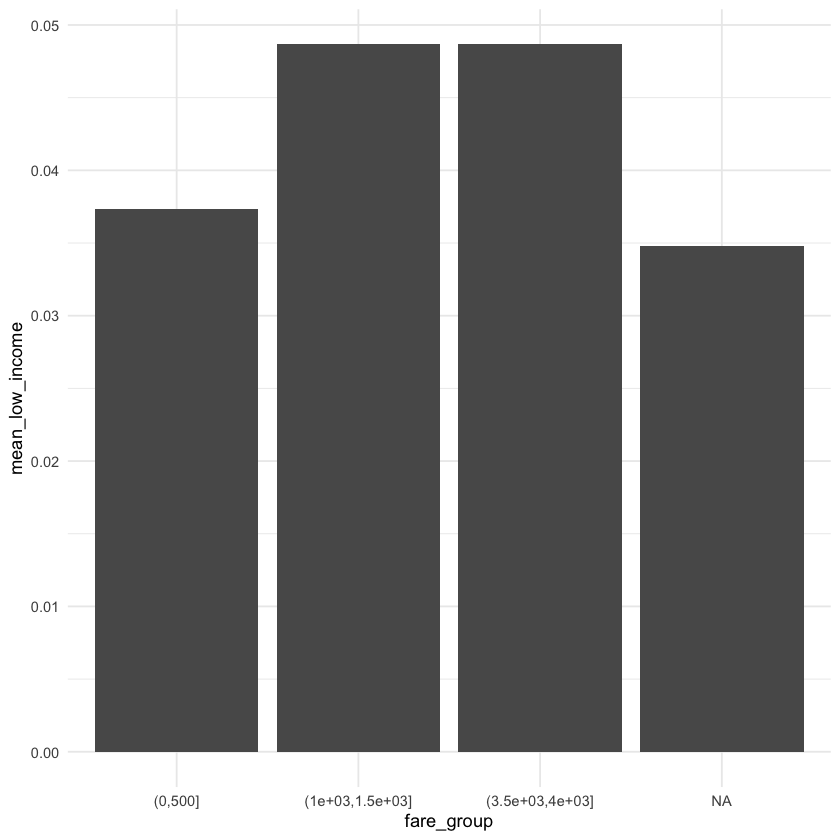

In [33]:
ggplot(income_share_aggregate, aes(x = fare_group, y = mean_low_income)) +
    geom_bar(stat = "identity") +
    theme_minimal()

In [39]:
income_share_noncom <- trip %>%
    select(id,
          toll,
           contains("inc"),
          tag_id) %>% 
    group_by(id) %>%
    summarize(fare_sum = sum(toll),
            low_income = mean(inc_000_010k),
             unique_tags = n_distinct(tag_id)) %>% # this should return total fare a user paid as well as their census info
    na.omit() %>%
    filter(fare_sum < 10000 ||
          unique_tags <= 6) %>% # there were several outliers that skewed the data very heavily 
    group_by(fare_group = cut(fare_sum, breaks = seq(0, max(fare_sum), 1000))) %>%
    summarize(mean_low_income = mean(low_income))

Warning message:
“Factor `fare_group` contains implicit NA, consider using `forcats::fct_explicit_na`”

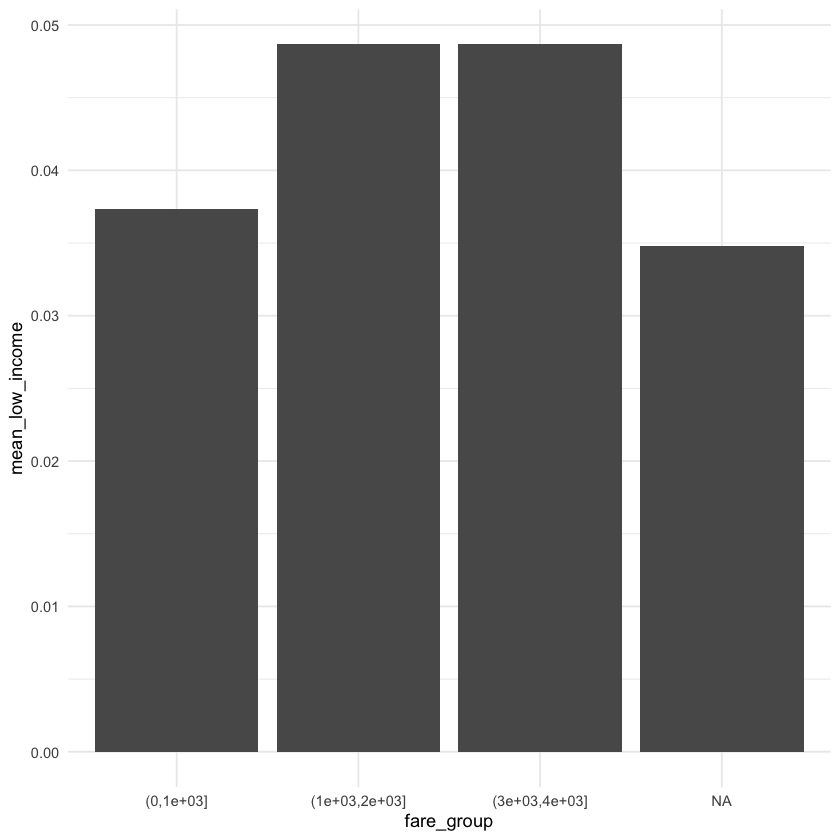

In [40]:
ggplot(income_share_noncom, aes(x = fare_group, y = mean_low_income)) +
    geom_bar(stat = "identity") +
    theme_minimal()

## Census Block Distribution

In [41]:
# creates files from trip data that will be joined w/ map
per_cap <- trip %>%
    select(is_hov,
           toll,
          fips,
          total_trips,
          trip_id, 
           commercial) %>%
    rename(fips_code = fips) %>%
    mutate(tot_ave_trips = mean(total_trips)) %>%
    filter(commercial == 0,
          total_trips < 700) %>%
    group_by(fips_code) %>%
    summarize(hov = sum(is_hov),
             trips = n(),
              users = sum(trip_id),
             average_toll = mean(toll),
             freq = sum(total_trips > 100) / users)

total_trips <- trip %>%
    select(trip_id,
          total_trips,
          fips) %>%
    rename(fips_code = fips) %>%
    group_by(trip_id) %>%
    glimpse() %>%
    group_by(fips_code) %>%
    summarize(average_total_trips = mean(total_trips))

# want to see how user frequency varies by census block group -- total by users, count each user once with their total tri

head(total_trips)

Observations: 155,185
Variables: 3
Groups: trip_id [155,185]
$ trip_id     <dbl> 110593099, 126082774, 135643442, 104428016, 133873543, 10…
$ total_trips <dbl> 58, 11, 56, 58, 32, 188, 52, 6, 19, 31, 2, 188, 10, 52, 2…
$ fips_code   <dbl> 5.3033e+11, 5.3033e+11, 5.3033e+11, 5.3033e+11, 5.3033e+1…


fips_code,average_total_trips
<dbl>,<dbl>
5.3033e+11,54.50000
5.3033e+11,70.66667
5.3033e+11,79.00000
5.3033e+11,158.07143
5.3033e+11,352.95652
5.3033e+11,136.71429


#### Set-Up

In [42]:
suppressWarnings(library(sf))
suppressWarnings(fips_shape <- read_sf(dsn = "../../data/shapefiles/block_groups/block_groups.shp"))

Linking to GEOS 3.6.1, GDAL 2.1.3, PROJ 4.9.3


In [43]:
fips_shape$fips_code <- as.numeric(fips_shape$fips_code)
fips_pc_map <- merge(fips_shape, per_cap, by = "fips_code")
fips_pc_map <- merge(fips_pc_map, total_trips, all.x = TRUE, by = "fips_code" )
fips_pc_map <- fips_pc_map %>%
    filter(trips < 2000) %>%
    select(fips_code, trips, hov, average_toll, freq, average_total_trips)

In [46]:
acs_est <- acs_est %>%
    rename(fips_code = fips)
fips_pc_map <- merge(fips_pc_map, acs_est, all.x = TRUE, by = "fips_code" )
fips_pc_map <- st_transform(fips_pc_map, crs = 4326)

### Creates Function to Plot 405 Corridor

In [47]:
plot_census <- function(data, variable, name) {
    washdot_shape <- read_sf("../../data/shapefiles/roads500k/sr500k_20181231.shp")
    city_shape <- read_sf("../../data/shapefiles/city_points/city_points.shp")
    washdot_shape <- washdot_shape[grep("405", washdot_shape$RouteID), ]
    washdot_shape <- st_transform(washdot_shape, crs = 4326)
    ggplot() + 
        geom_sf(data = data, aes(fill = variable), lwd = 0, color = NA) +
        geom_sf(data = washdot_shape, color = "palegreen") +
        coord_sf(xlim=c(-122.35, -122), ylim=c(48.4, 47.3)) +
        labs(fill = name) +
        scale_color_viridis_c()
    }

#### Distribution of Raw Trips

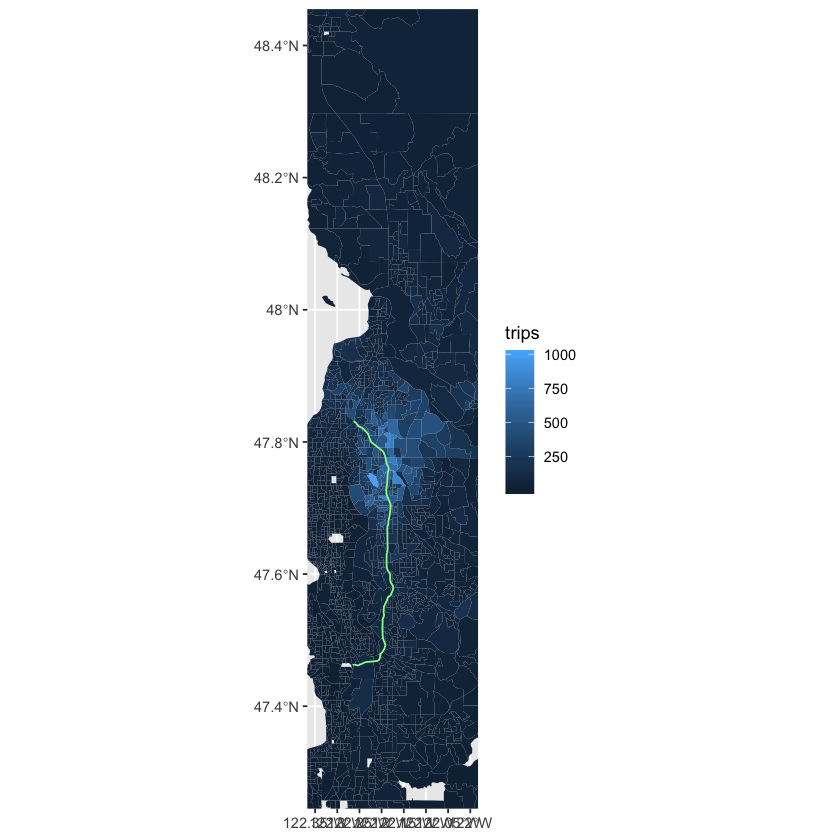

In [48]:
plot_census(fips_pc_map, fips_pc_map$trips, "trips")

#### Distribution of Median Income

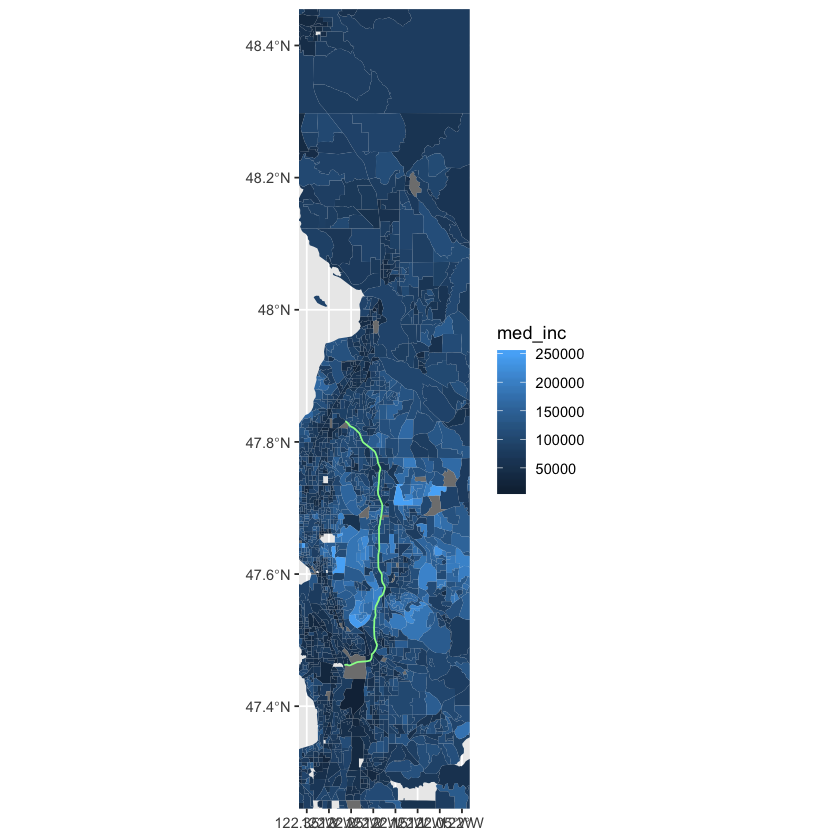

In [49]:
plot_census(fips_pc_map, fips_pc_map$med_inc, "med_inc")

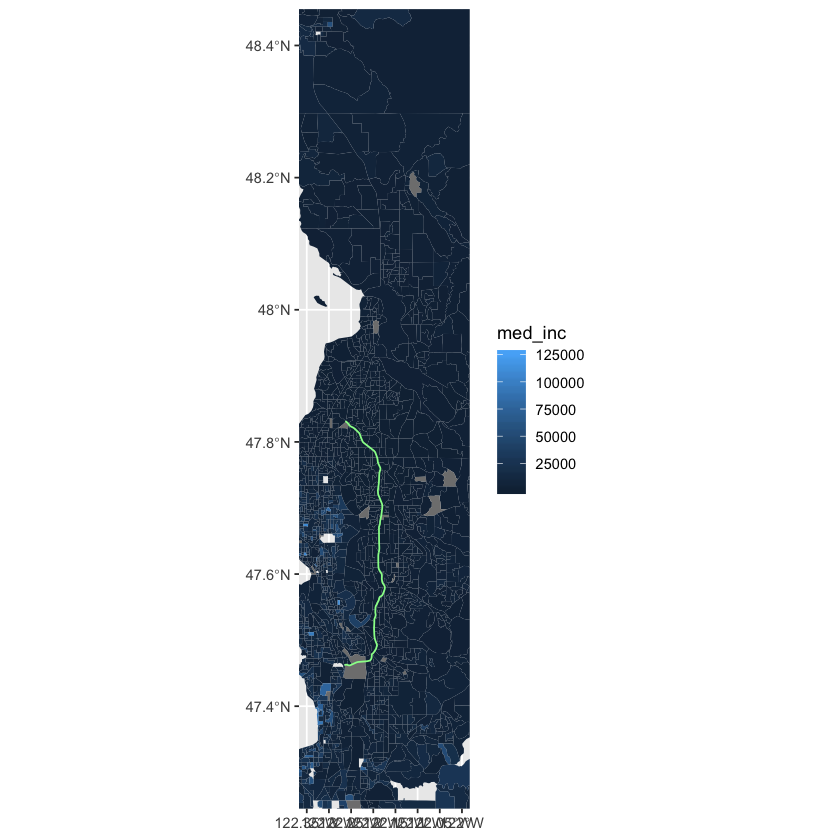

In [70]:
plot_census(fips_pc_map, fips_pc_map$med_inc / fips_pc_map$trips, "med_inc")

#### Distributions of Trips Per Capita

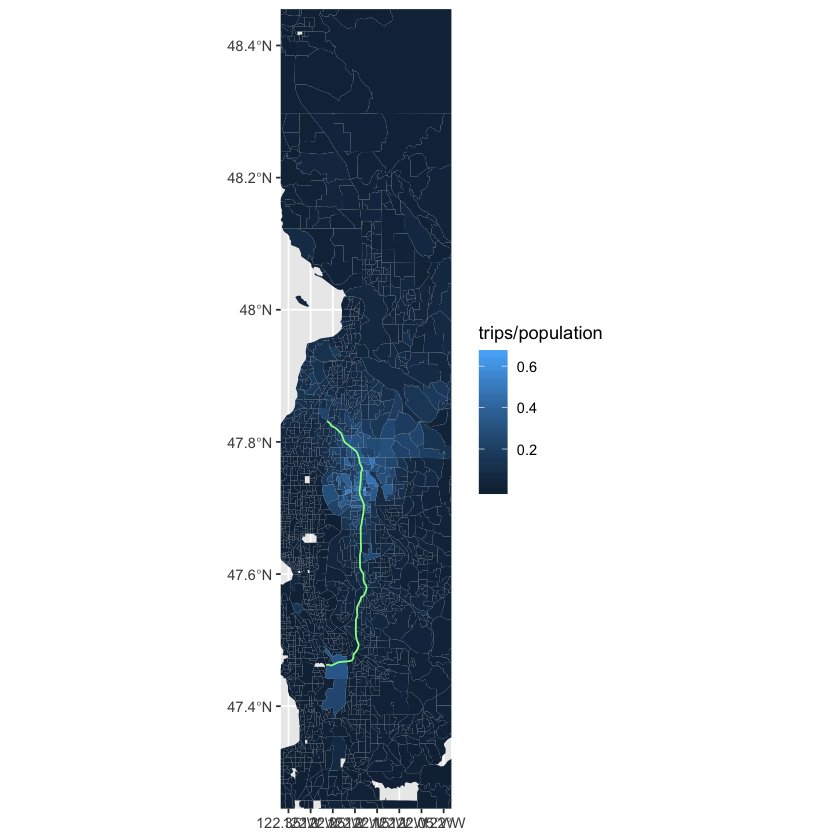

In [50]:
plot_census(fips_pc_map, fips_pc_map$trips / fips_pc_map$population, "trips/population")

#### Distribution of Average Toll Paid by Block

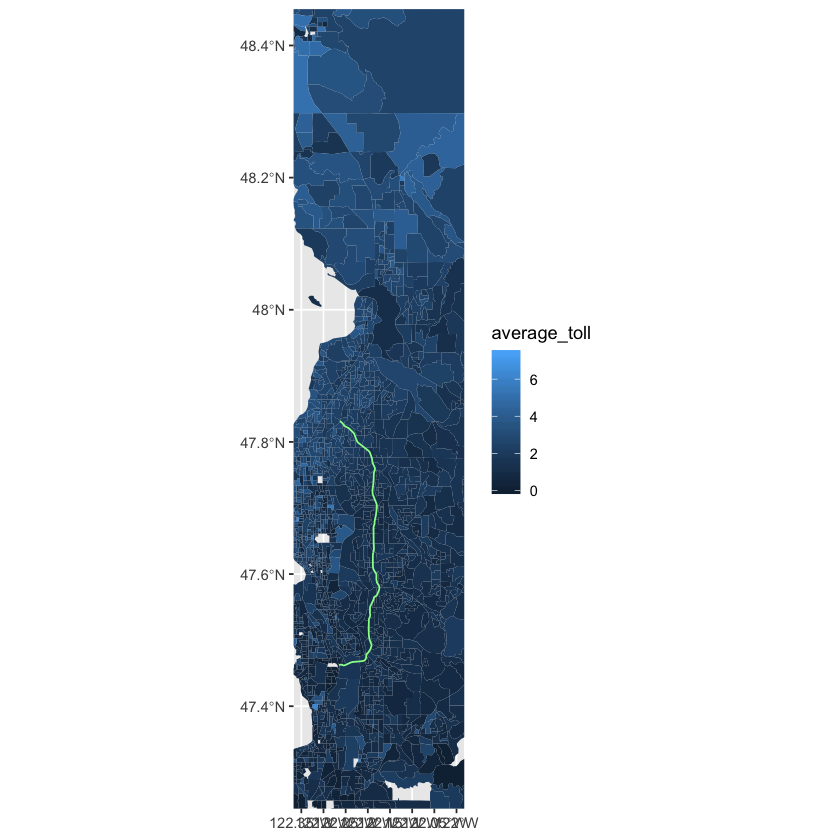

In [51]:
toll_map <- fips_pc_map %>%
    filter(average_toll < 7.5) 

plot_census(toll_map, toll_map$average_toll, "average_toll")

#### Fraction of High Freq Users

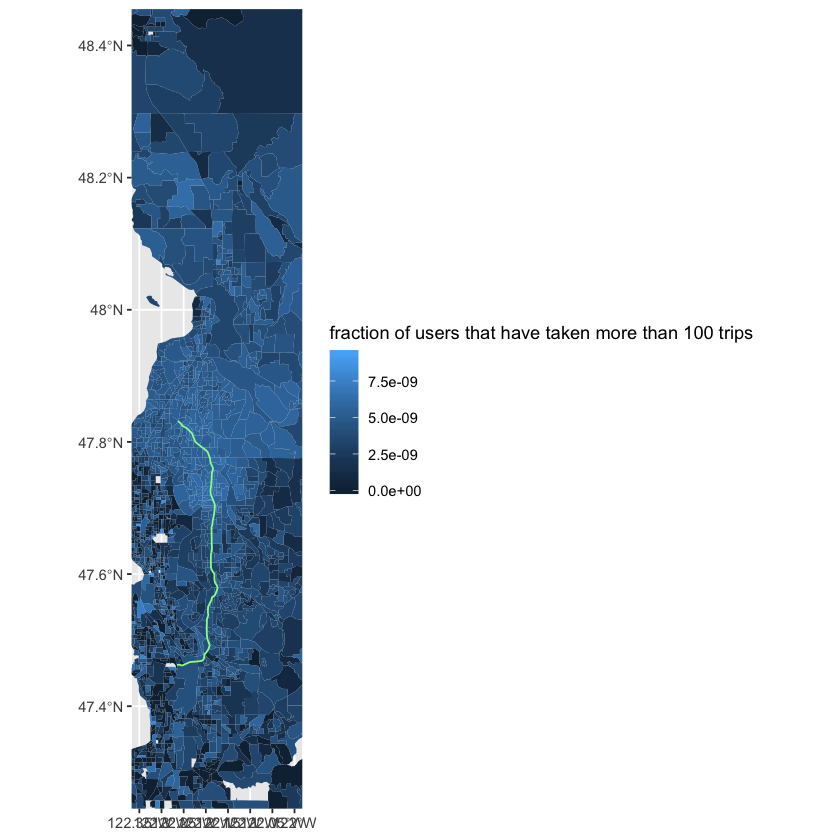

In [52]:
plot_census(fips_pc_map, fips_pc_map$freq, "fraction of users that have taken more than 100 trips")

#### Average Total Trips by User in Block

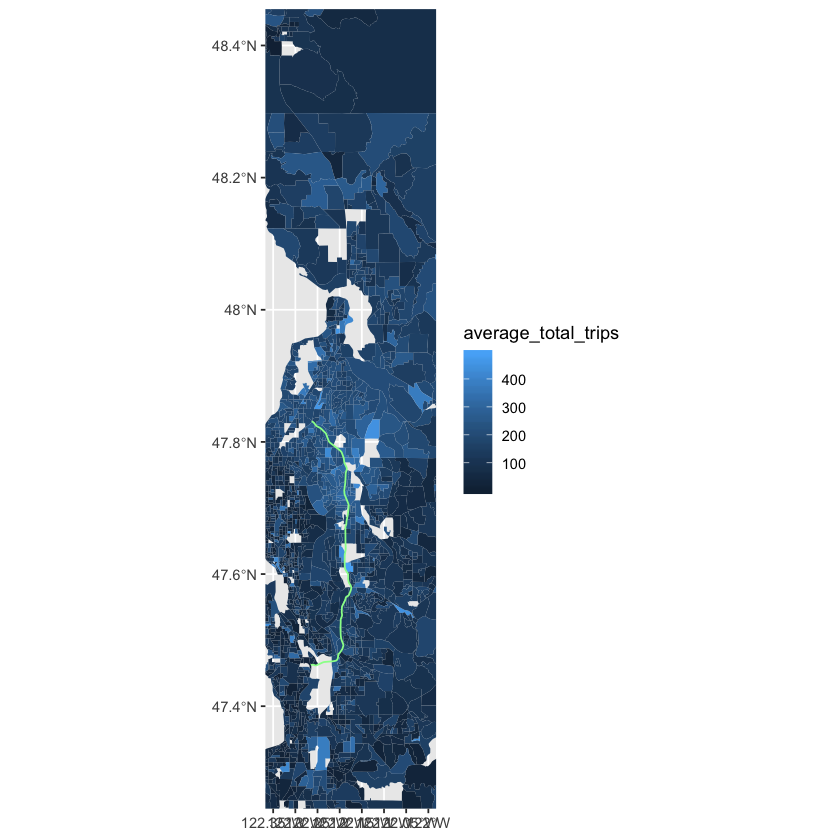

In [53]:
fips_pc_map_smalltrips <- fips_pc_map %>%
    filter(average_total_trips <500)
plot_census(fips_pc_map_smalltrips, fips_pc_map_smalltrips$average_total_trips, "average_total_trips")

## County Income Distribution
I was interested in how income was distributed among counties, becomes it seemed that the northern area of the corridor (Lynnwood) was paying higher prices, and I was curious if this region held a larger amount of high-income people that could afford to take longer commutes. This did not seem to be the case - there's a larger proportion of middle-income people.

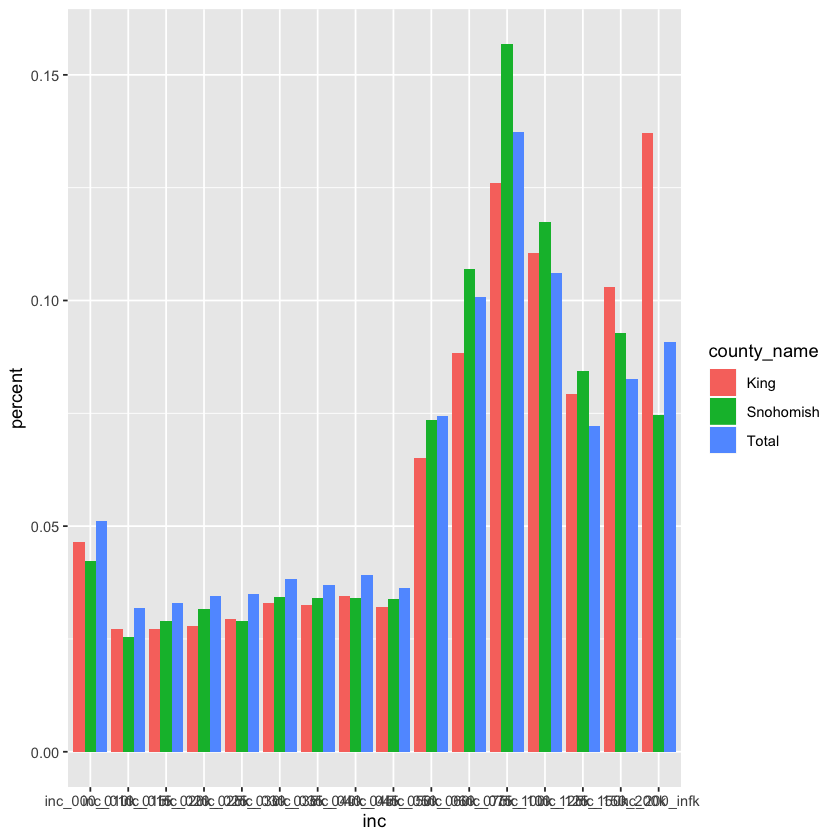

In [54]:
king_sno <- acs_est %>%
    group_by(county_name) %>%
    summarize_at(vars(starts_with("inc")), mean, na.rm = T) %>%
    filter(county_name == "Snohomish"|
          county_name == "King") %>%
    gather(inc, percent, inc_000_010k:inc_200_infk)

total <- acs_est %>%
    summarize_at(vars(starts_with("inc")), mean, na.rm = T) %>%
    gather(inc, percent) %>%
    mutate(county_name = "Total")

county_inc <- rbind(total, king_sno)

ggplot(county_inc, aes(x = inc, y = percent, fill = county_name)) + 
    geom_bar(stat = "identity", position = "dodge")

### Distribution of Toll Paid for Single-Time Users

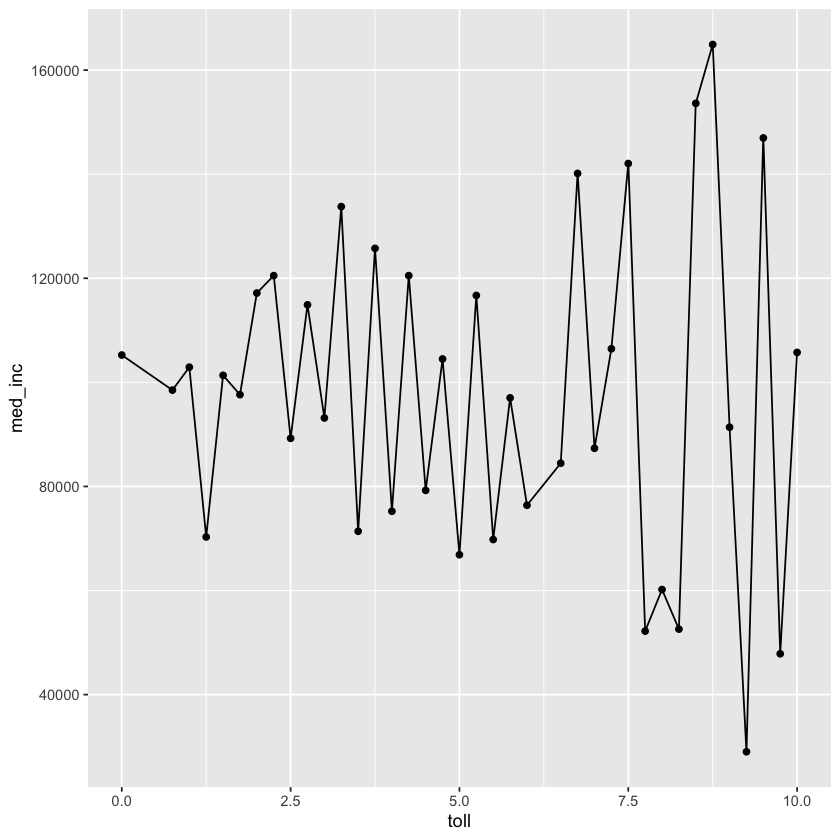

In [64]:
fare_rounded %>%
    filter(commercial == 0,
           total_trips == 1) %>% 
    group_by(toll) %>%
    summarize(med_inc = median(med_inc)) %>%
ggplot(aes(x = toll, y = med_inc)) + 
    geom_point() +
    geom_line()

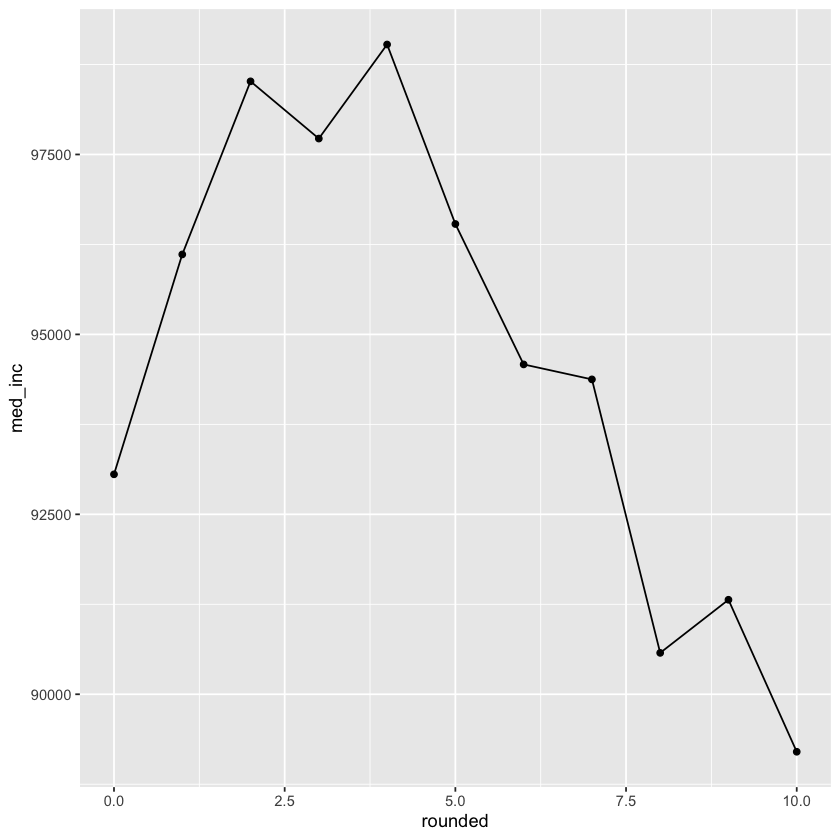

In [56]:
fare_rounded %>%
    filter(commercial == 0,
          grepl("^53061", fips)) %>% 
    mutate(rounded = round(toll)) %>%
    group_by(rounded) %>%
    summarize(med_inc = median(med_inc)) %>%
ggplot(aes(x = rounded, y = med_inc)) + 
    geom_point() +
    geom_line()

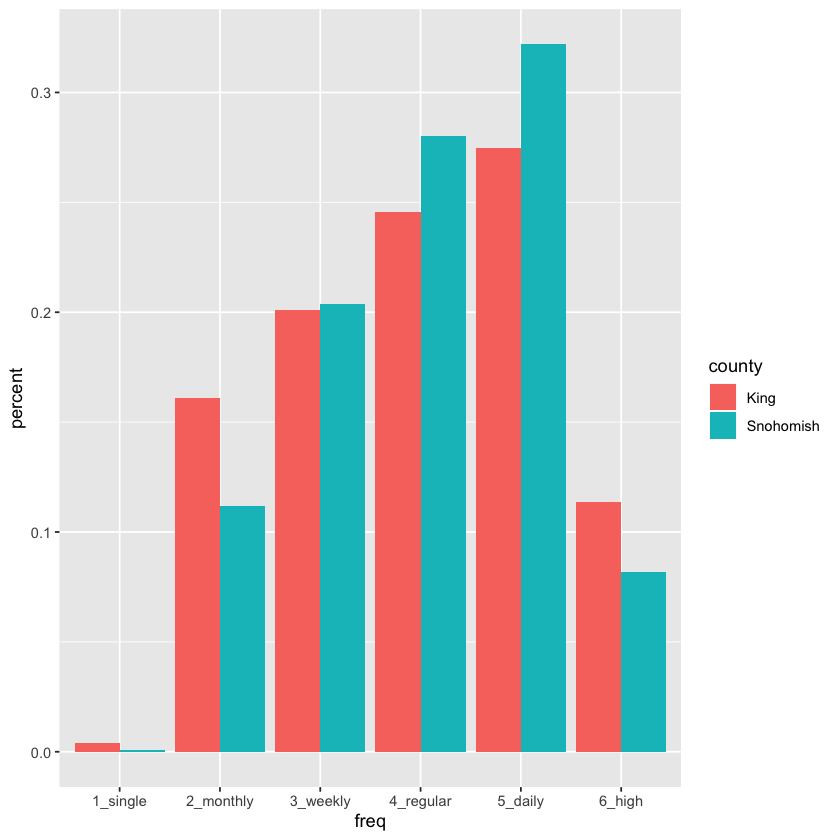

In [57]:
sno_freq <- fare_rounded %>%
    filter(grepl("^53061", fips)) %>%
    group_by(freq) %>%
    summarize(count = n()) %>%
    mutate(percent = count / sum(count),
           county = "Snohomish") 

king_freq <- fare_rounded %>%
    filter(grepl("^53033", fips)) %>%
    group_by(freq) %>%
    summarize(count = n()) %>%
    mutate(percent = count / sum(count),
          county = "King")

rbind(sno_freq, king_freq) %>%
ggplot(aes(x = freq, y = percent, fill = county)) + 
    geom_bar(stat = "identity", position = "dodge")

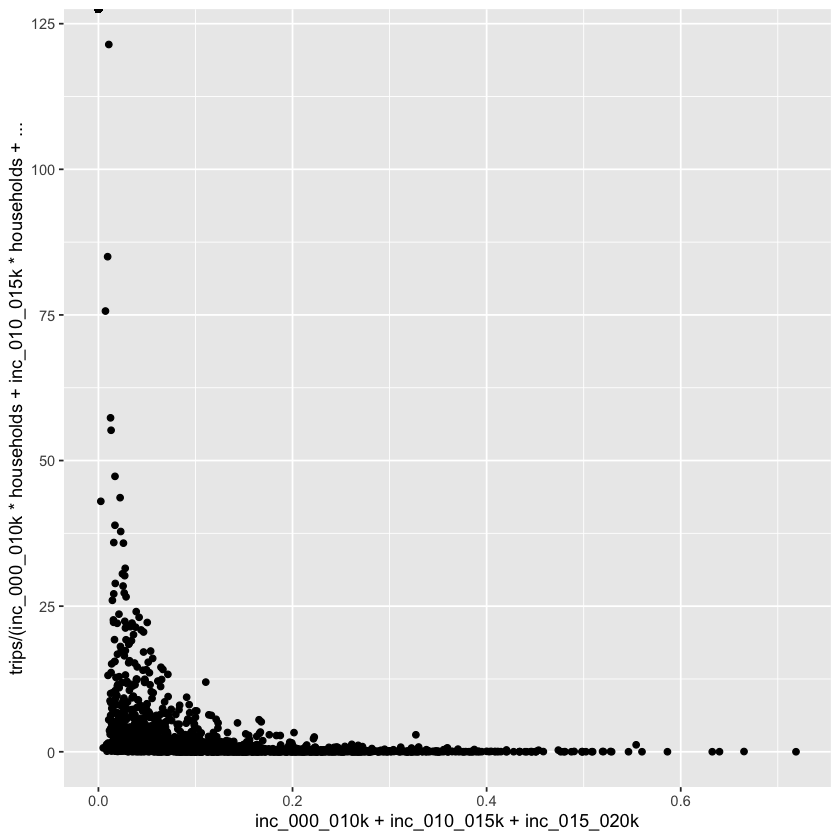

In [58]:
ggplot(fips_pc_map, aes(x = inc_000_010k + inc_010_015k + inc_015_020k, y = trips / (inc_000_010k * households + inc_010_015k * households + inc_015_020k * households))) +
       geom_point()

## Daylight Savings???
A WSDOT vendor did not care about daylight savings time -- we have corrected for this, so the graph doesn't show anything indicating no tolls happened after 7pm

In [59]:
trips_2pct <- trips_2pct %>%
    execute

Warning message:
“12 parsing failures.
  row col expected actual         file
23087 zip a double v7b1k7 literal data
32084 zip a double V3W7X4 literal data
69739 zip a double V3W7X4 literal data
75337 zip a double V3W7X4 literal data
87441 zip a double V3W7X4 literal data
..... ... ........ ...... ............
See problems(...) for more details.
”

In [60]:
trips_2pct$hour <- as_datetime(trips_2pct$entry_time)
trips_2pct$hour <- hour(trips_2pct$hour)

In [61]:
weird <- trips_2pct %>%
    filter(hour == 19)

In [62]:
weird$date <- as_datetime(weird$entry_time)
weird$date <- date(weird$date)
weird$minute <- as_datetime(weird$entry_time)
weird$minute <- minute(weird$minute)
weird$hour_min <- weird$hour + weird$minute / 60

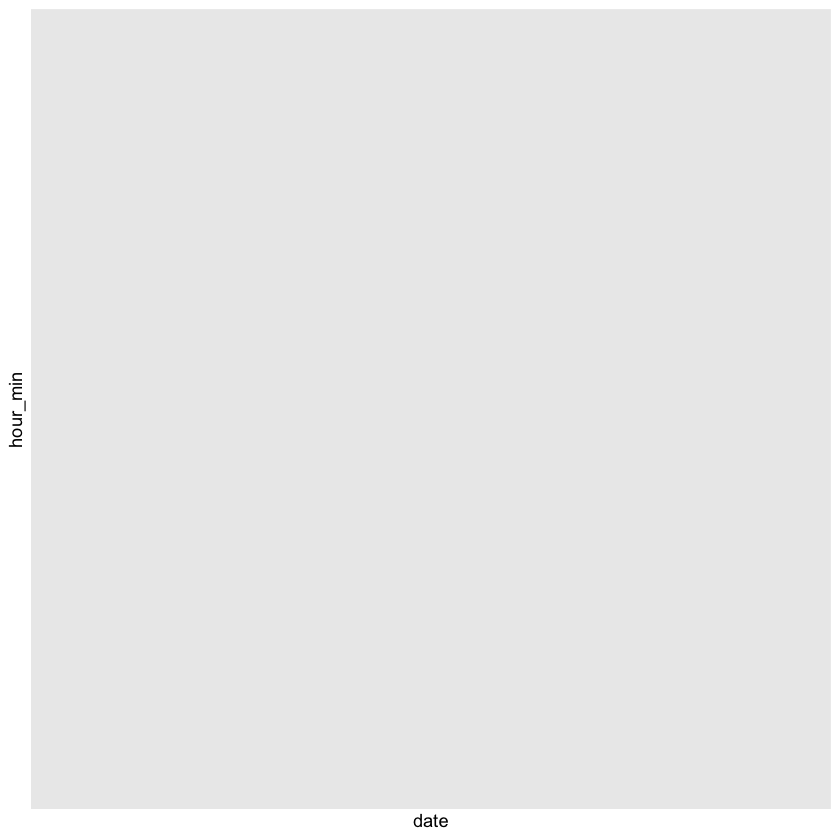

In [63]:
ggplot(weird, aes(x = date, y = hour_min)) +
    geom_point()